In [1]:
! pip install session_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nltk
import re
import session_info

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [4]:
sns.set_context('talk')

In [5]:
session_info.show()

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data

In [7]:
data_file = 'DSP453_ClassCorpus_v1.csv'

In [8]:
class_corpus = pd.read_csv(data_file)

In [9]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    100 non-null    int64 
 1   DSI_Title                 100 non-null    object
 2   Text                      100 non-null    object
 3   Submission File Name      100 non-null    object
 4   Student Name              100 non-null    object
 5   Genre of Movie            100 non-null    object
 6   Review Type (pos or neg)  100 non-null    object
 7   Movie Title               100 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.4+ KB


# Preprocessing

In [10]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [11]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [12]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [13]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)
    
    return tokenized_text

In [14]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [15]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [16]:
class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [17]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Doc_ID                    100 non-null    int64 
 1   DSI_Title                 100 non-null    object
 2   Text                      100 non-null    object
 3   Submission File Name      100 non-null    object
 4   Student Name              100 non-null    object
 5   Genre of Movie            100 non-null    object
 6   Review Type (pos or neg)  100 non-null    object
 7   Movie Title               100 non-null    object
 8   normalized_review         100 non-null    object
 9   tokenized_review          100 non-null    object
 10  lemmatized_tokens         100 non-null    object
 11  lemmatized_text           100 non-null    object
dtypes: int64(1), object(11)
memory usage: 9.5+ KB


# Feature Extraction

## Method 1: TF-IDF

In [18]:
tfidf_vectorizer = TfidfVectorizer()

In [19]:
dtm_class_corpus = tfidf_vectorizer.fit_transform(class_corpus['lemmatized_text'])

In [20]:
features_tfidf_scores = pd.DataFrame(dtm_class_corpus.toarray(), 
                                     columns=tfidf_vectorizer.get_feature_names_out(), 
                                     index=class_corpus.index)

In [21]:
features_tfidf_scores.shape

(100, 8799)

## Method 2: Doc2Vec

In [22]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [23]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=200,
                        min_count=1,
                        workers=4)

In [24]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [25]:
features_doc2vec.shape

(100, 200)

# Clustering

Before clustering, we need to scale the data to bring parity between all the columns. 

In [26]:
standard_scaler = StandardScaler()

In [27]:
help(StandardScaler)

Help on class StandardScaler in module sklearn.preprocessing._data:

class StandardScaler(sklearn.base._OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  StandardScaler(*, copy=True, with_mean=True, with_std=True)
 |  
 |  Standardize features by removing the mean and scaling to unit variance.
 |  
 |  The standard score of a sample `x` is calculated as:
 |  
 |      z = (x - u) / s
 |  
 |  where `u` is the mean of the training samples or zero if `with_mean=False`,
 |  and `s` is the standard deviation of the training samples or one if
 |  `with_std=False`.
 |  
 |  Centering and scaling happen independently on each feature by computing
 |  the relevant statistics on the samples in the training set. Mean and
 |  standard deviation are then stored to be used on later data using
 |  :meth:`transform`.
 |  
 |  Standardization of a dataset is a common requirement for many
 |  machine learning estimators: they might behave badly if the
 |  individual fea

In [28]:
transformed_features_doc2vec = standard_scaler.fit_transform(features_doc2vec)

In [29]:
model_kmeans = KMeans(n_clusters=4, 
                      random_state=20130810)

In [30]:
model_kmeans.fit(transformed_features_doc2vec)

KMeans(n_clusters=4, random_state=20130810)

In [31]:
labels_kmeans = model_kmeans.labels_

Quality of clustering is determined using the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

In [32]:
silhouette_score(transformed_features_doc2vec, labels_kmeans)

0.5428278

In [33]:
for k in [4, 5, 6, 7, 8, 9]:
    
    model_kmeans = KMeans(n_clusters=k, 
                          random_state=20130810)
    model_kmeans.fit(transformed_features_doc2vec)
    sil_score = silhouette_score(transformed_features_doc2vec, model_kmeans.labels_)
    print(f"k = {k}, silhouette score = {sil_score}")

k = 4, silhouette score = 0.5428277850151062
k = 5, silhouette score = 0.42832741141319275
k = 6, silhouette score = 0.39281323552131653
k = 7, silhouette score = 0.38188624382019043
k = 8, silhouette score = 0.3872436285018921
k = 9, silhouette score = 0.380888432264328


In [34]:
model_kmeans = KMeans(n_clusters=4)
model_kmeans.fit(transformed_features_doc2vec)
labels_kmeans = model_kmeans.labels_

In [35]:
model_tsne = TSNE(n_components=2)

In [36]:
transformed_values = model_tsne.fit_transform(transformed_features_doc2vec)
X, Y = [], []

for value in transformed_values:
    X.append(value[0])
    Y.append(value[1])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


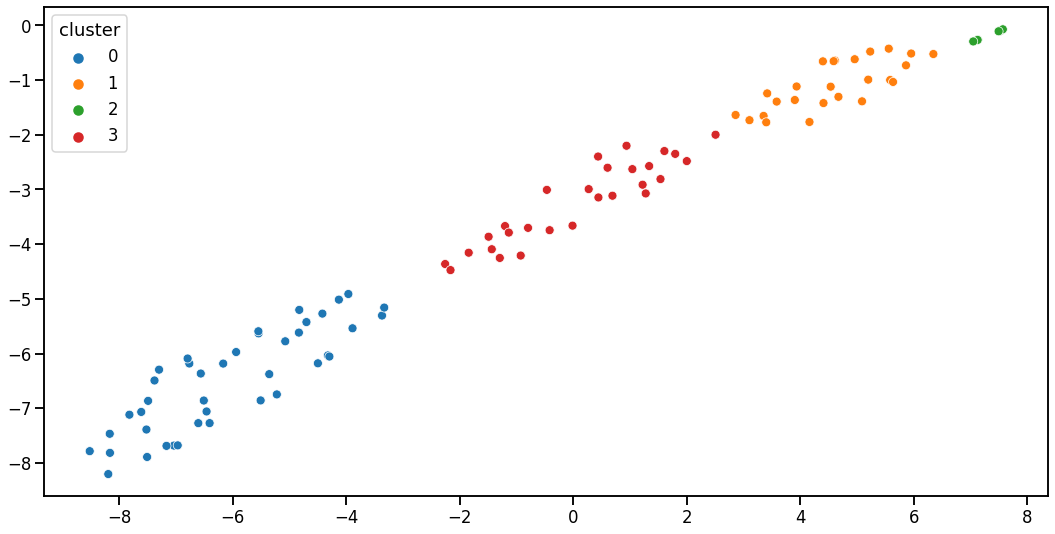

In [37]:
plt.figure(figsize=(18, 9))

labels_kmeans_str = pd.Series(labels_kmeans.astype(str), name='cluster')

sns.scatterplot(x=X, 
                y=Y, 
                hue=labels_kmeans_str,
                hue_order=['0', '1', '2', '3'])

Once the cluster assignment is done, we can then look at the composition of the clusters to qualitatively assess the clusters.

In [38]:
documents_by_cluster = (class_corpus.loc[:, ['DSI_Title', 'Genre of Movie', 'Text']]
                                    .assign(cluster_label=labels_kmeans))

In [39]:
documents_by_cluster.query(f"cluster_label == 1")

,DSI_Title,Genre of Movie,Text,cluster_label
1,HBW_Doc2_HolmesAndWatson,Comedy,"""ï¿½Holmes & Watsonï¿½ Review: No, Sh-t Sherlo...",1
2,HBW_Doc3_HolmesAndWatson,Comedy,"""It is often said that Sherlock Holmes, the le...",1
3,HBW_Doc4_HolmesAndWatson,Comedy,"""Holmes & Watson wasnï¿½t shown at all to the ...",1
4,HBW_Doc5_HolmesAndWatson,Comedy,"""ï¿½Holmes & Watsonï¿½ Review: Will Ferrell an...",1
5,HBW_Doc6_HolmesAndWatson,Comedy,"""Despite evidence to the contrary, Holmes and ...",1
6,HBW_Doc7_HolmesAndWatson,Comedy,"""The comedy so execrable that audiences evacua...",1
8,HBW_Doc9_HolmesAndWatson,Comedy,"""Holmes & Watson Doesnï¿½t Make It Easy, But T...",1
10,AVC_Doc1_DirtyGrandpa,Comedy,"""Robert De Niro has been nominated for an Acad...",1
16,AVC_Doc7_DirtyGrandpa,Comedy,"""In 2016, this head-scratching cinematic anoma...",1
17,AVC_Doc8_DirtyGrandpa,Comedy,"""It's one of those boilerplates about an uptig...",1


# Conclusion

Quality of features extracted from text (e.g., `tf-idf` and `doc2vec`) can be acertained by the quality of the clusters generated using these features. These clusters also highlight potential patterns within the corpus.
 